In [179]:
from ase import Atoms
import numpy as np
from dscribe.descriptors import SOAP
import matplotlib.pyplot as plt
import ase.io.gromacs as gmx
from seaborn import kdeplot
import MDAnalysis as mda
from MDAnalysis.lib.mdamath import triclinic_vectors as tv

In [180]:
import numpy as np
import tqdm.auto as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [181]:
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
os.chdir("/home/dibyendu/DM_Projects/SolOrder/SolOrder/")

In [77]:
from sklearn.model_selection import train_test_split
import seaborn as sns

In [78]:
class AE(nn.Module):
    
    def __init__(self, input_dim,train_data, val_data, hidden1 = 128, hidden2 = 40,hidden3=None, hidden4 = None,
                 code = 2, learning_rate=0.00001,batch_size=64, epochs=50,
                 shuffle=True, thresh = 0.0001):
        
        """
        input_dim : flattened input vector length
        hidden1 : node number of hidden layer 1
        hidden2 : node number of hidden layer 2
        code : dimension of latent space
        learning_rate : name suggests
        thresh : thresh to compare while earlystopping
        train_data : trainning dataset
        val_data : validation dataset
        """
        
        super(AE, self).__init__()
        
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.thresh = thresh
        self.learning_rate = learning_rate
        self.train_data = train_data
        self.val_data = val_data
        
        torch.manual_seed(1)
        np.random.seed(1)
        # Encoder block
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, hidden4),
            nn.ReLU(),
            nn.Linear(hidden4, code),

        )
        # Decoder block
        self.decoder = nn.Sequential(
            nn.Linear(code, hidden4),
            nn.ReLU(),
            nn.Linear(hidden4, hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)
    
    def fit(self):
        
        if torch.cuda.is_available():
            self.to('cuda')
        train_dataset = TensorDataset(torch.Tensor(self.train_data))
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)

        val_dataset = TensorDataset(torch.Tensor(self.val_data))
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=self.shuffle)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        best_val_loss = float('inf')
        prv = float('inf')
        stop_counter = 0
        for epoch in range(self.epochs):
            train_loss = 0
            for x_batch, in train_dataloader:
                x_batch = x_batch.to('cuda') if torch.cuda.is_available() else x_batch
                optimizer.zero_grad()
                decoded = self(x_batch)
                loss = criterion(decoded, x_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            val_loss = 0
            for x_batch, in val_dataloader:
                x_batch = x_batch.to('cuda') if torch.cuda.is_available() else x_batch
                decoded = self(x_batch)
                loss = criterion(decoded, x_batch)
                val_loss += loss.item()
            val_loss = val_loss / len(val_dataloader)
            if abs(val_loss - prv) < self.thresh:
                break
            elif val_loss < best_val_loss:
                best_val_loss = val_loss
                stop_counter = 0
                # You can save the best model using torch.save(self.state_dict(), 'best_model.pt')
            else:
                stop_counter += 1
                if stop_counter >= 2:
                    print('Early stopping')
                    break
                    
            prv = val_loss

            print(f'Epoch: {epoch + 1}/{self.epochs} | '
                  f'Train Loss: {train_loss / len(train_dataloader):.5f} | '
                  f'Val Loss: {val_loss:.5f} | ')


In [229]:
species = ["H", "O"]
r_cut = 20
n_max = 7
l_max = 7

# Setting up the SOAP descriptor
soap = SOAP(
    species=[1, 8],
    periodic=True,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    average = 'off',
    rbf='gto',
)

In [230]:
#test_ice0 = mda.Universe("../../Sample_Structures/Ice/ice0.gro")

In [182]:
ice1h = mda.Universe("../../Sample_Structures/Inherent/ice1h/ice1h.gro")
ice1c = mda.Universe("../../Sample_Structures/Inherent/ice1c/ice1c.gro")
ice0 = mda.Universe("../../Sample_Structures/Inherent/ice0/ice0.gro")
ice2 = mda.Universe("../../Sample_Structures/Inherent/ice2/ice2.gro")
ice3 = mda.Universe("../../Sample_Structures/Inherent/ice3/ice3.gro")
ice4 = mda.Universe("../../Sample_Structures/Inherent/ice4/ice4.gro")
ice5 = mda.Universe("../../Sample_Structures/Inherent/ice5/ice5.gro")
ice6 = mda.Universe("../../Sample_Structures/Inherent/ice6/ice6.gro")
ice7 = mda.Universe("../../Sample_Structures/Inherent/ice7/ice7.gro")
ice9 = mda.Universe("../../Sample_Structures/Inherent/ice9/ice9.gro")
ice12 = mda.Universe("../../Sample_Structures/Inherent/ice12/ice12.gro")
iceA = mda.Universe("../../Sample_Structures/Inherent/iceA/iceA.gro")
iceB = mda.Universe("../../Sample_Structures/Inherent/iceB/iceB.gro")

In [222]:
# Define the system under study: NaCl in a conventional cell.
def soaper(u):
    pos = u.select_atoms("not name MW").positions
    #scale_pos = pos - pos.min(axis = 0)
    #scale_pos /= scale_pos.max()
    conv = Atoms(
        cell=tv(u.dimensions),
        positions=pos, 
        symbols=["O", "H", "H"]*len(u.select_atoms("name OW").positions),pbc = True)
    return soap.create(conv, positions=np.arange(0, len(pos), 3))

In [231]:
soap_ih = soaper(ice1h)
soap_ic = soaper(ice1c)
soap_0 = soaper(ice0)
soap_2 = soaper(ice2)
soap_3 = soaper(ice3)
soap_4 = soaper(ice4)
soap_5 = soaper(ice5)
soap_6 = soaper(ice6)
soap_7 = soaper(ice7)
soap_9 = soaper(ice9)
soap_12 = soaper(ice12)
soap_A = soaper(iceA)
soap_B = soaper(iceB)

In [84]:
#test_soap_0 = soaper(test_ice0)
#test_soap_0

In [85]:
#soap_0

In [100]:
soap.get_number_of_features()

546

In [224]:
data = np.concatenate([soap_ih, soap_ic, soap_0, soap_2, soap_3, soap_4, soap_5, soap_6, soap_7, soap_9, soap_12, soap_A, soap_B])

In [185]:
shift_list = []
scale_list = []
for i in range(546):
    shift_list.append(data[:,i].min())
    new_data = data[:,i] - data[:,i].min()
    scale_list.append(np.max(new_data))
    new_data = new_data/np.max(new_data)
    data[:,i] = new_data

In [213]:
data.shape

(142640, 840)

In [225]:
scaler = MinMaxScaler()
scaler.fit(data)
datafit = scaler.transform(data)
X_train, X_test, y_train, y_test = train_test_split(datafit, datafit, test_size=0.20, random_state=42)

In [226]:
pyenc = AE(840,X_train, X_test, hidden1 = 1000, hidden2 = 500,hidden3=500 , hidden4=128,
                 code = 2, learning_rate=0.00001,batch_size=64, epochs=100,
                 shuffle=True, thresh = 0.00001)
pyenc.fit()

Epoch: 1/100 | Train Loss: 0.05524 | Val Loss: 0.01475 | 
Epoch: 2/100 | Train Loss: 0.00956 | Val Loss: 0.00669 | 
Epoch: 3/100 | Train Loss: 0.00478 | Val Loss: 0.00374 | 
Epoch: 4/100 | Train Loss: 0.00311 | Val Loss: 0.00274 | 
Epoch: 5/100 | Train Loss: 0.00256 | Val Loss: 0.00241 | 
Epoch: 6/100 | Train Loss: 0.00227 | Val Loss: 0.00215 | 
Epoch: 7/100 | Train Loss: 0.00207 | Val Loss: 0.00197 | 
Epoch: 8/100 | Train Loss: 0.00187 | Val Loss: 0.00175 | 
Epoch: 9/100 | Train Loss: 0.00168 | Val Loss: 0.00161 | 
Epoch: 10/100 | Train Loss: 0.00159 | Val Loss: 0.00154 | 
Epoch: 11/100 | Train Loss: 0.00152 | Val Loss: 0.00148 | 
Epoch: 12/100 | Train Loss: 0.00148 | Val Loss: 0.00144 | 
Epoch: 13/100 | Train Loss: 0.00143 | Val Loss: 0.00140 | 
Epoch: 14/100 | Train Loss: 0.00138 | Val Loss: 0.00135 | 
Epoch: 15/100 | Train Loss: 0.00134 | Val Loss: 0.00130 | 
Epoch: 16/100 | Train Loss: 0.00130 | Val Loss: 0.00127 | 
Epoch: 17/100 | Train Loss: 0.00125 | Val Loss: 0.00121 | 
Epoch:

In [227]:
color_list = []
#for i, dt in enumerate([soap_ih, soap_0, soap_2, soap_3, soap_4, soap_5, soap_6, soap_7, soap_9, soap_12, soap_A, soap_B, soap_ic, soap_lq]):
for i, dt in enumerate([soap_ih, soap_ic, soap_0, soap_2, soap_3, soap_4, soap_5, soap_6, soap_7, soap_9, soap_12, soap_A, soap_B]):
    color_list.extend(np.ones(len(dt))*i)

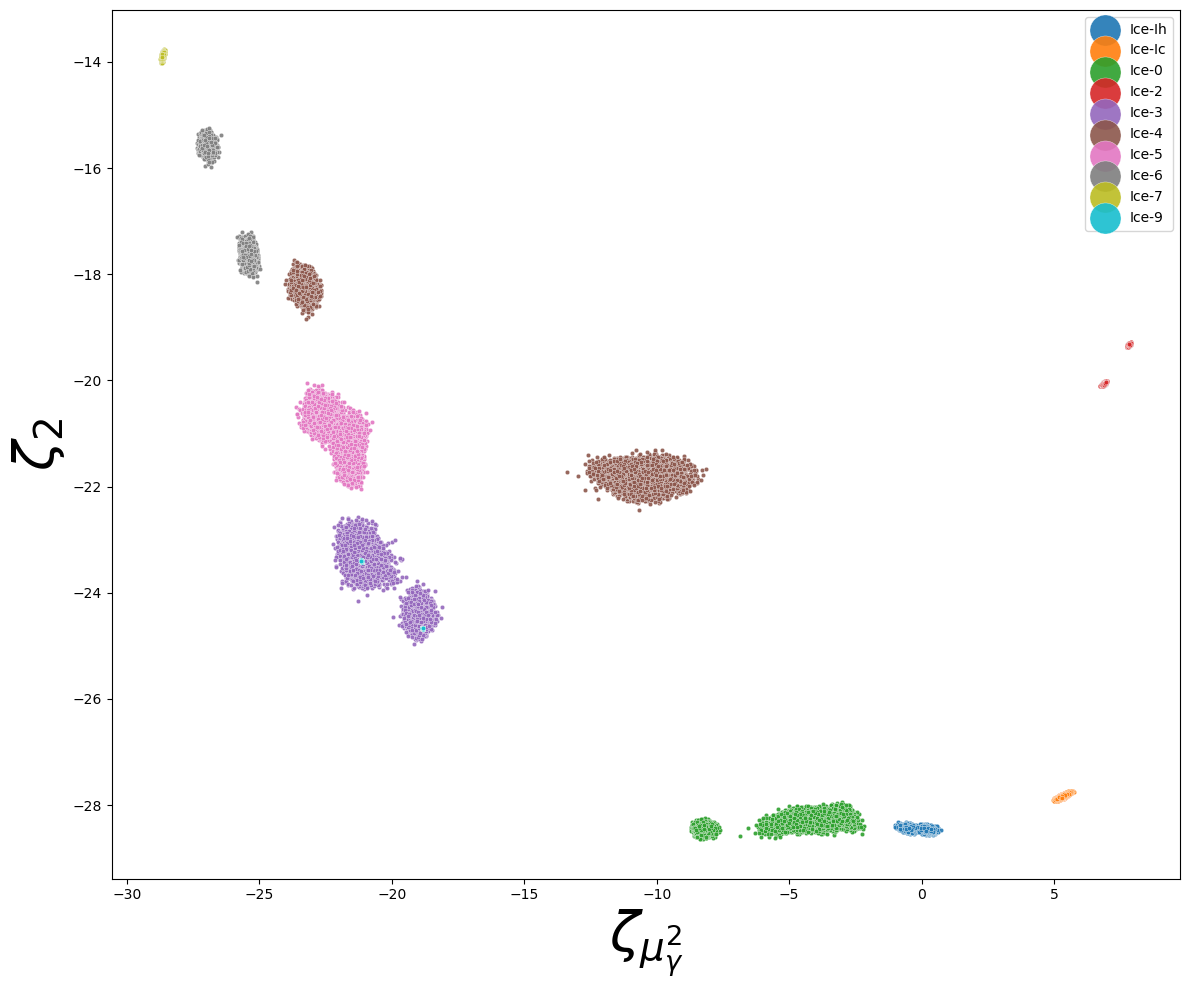

In [228]:
plt.figure(figsize = [12,10])
pyTrain0 = pyenc.encoder(torch.Tensor(datafit).to('cuda')).detach().to('cpu').to().numpy()
labels = ["Ice-Ih", "Ice-Ic", "Ice-0", "Ice-2","Ice-3",  "Ice-4", "Ice-5", "Ice-6", "Ice-7", "Ice-9", "Ice-12", "Ice-A", "Ice-B",]
for i in [0,1,2,3,4, 5,6,7,8,9]:
    color = np.array(color_list)
    #if i not in [1,4,5,6,7]:
    sns.scatterplot(x = pyTrain0[:,0][color==i], y = pyTrain0[:,1][color==i], s = 10, label = labels[i], alpha = 0.9)
lgnd = plt.legend()
#data0 = pyenc.encoder(torch.Tensor(ice_0_data).to('cuda')).detach().to('cpu').to().numpy() 
#sns.scatterplot(x= data0[:,0], y = data0[:,1], s = 1)
for handle in lgnd.legendHandles:
    handle.set_sizes([500.0])
plt.xlabel("$\zeta_{\mu^2_\gamma}$", fontsize = 40)
plt.ylabel("$\zeta_2$", fontsize = 40)
plt.tight_layout()

In [244]:
from vae import VAE

In [245]:
X_train

array([[0.02002007, 0.96155655, 0.01824693, ..., 0.44447967, 0.58130951,
        0.12081508],
       [0.96867655, 0.0235359 , 0.97050951, ..., 0.00312786, 0.99470143,
        0.45704944],
       [0.92314917, 0.0371822 , 0.92468062, ..., 0.00287349, 0.99424097,
        0.44152603],
       ...,
       [0.55008031, 0.30948487, 0.52158947, ..., 0.04830839, 0.82829372,
        0.08572682],
       [0.10795412, 0.83117145, 0.09894779, ..., 0.46171734, 0.26233838,
        0.5642781 ],
       [0.49669188, 0.36000524, 0.4677226 , ..., 0.08866078, 0.63675213,
        0.58025016]])

In [246]:
v = VAE(546,X_train, X_test, hidden1 = 1024, hidden2 = 128,hidden3=32,
    code = 2, learning_rate=0.00001,batch_size=128, epochs=500,
    shuffle=True, thresh = 0.01)
v.fit()

Epoch: 1/500 | Train Loss: 7114.60903 | Val Loss: 3584.03605 | 
Epoch: 2/500 | Train Loss: 2474.45119 | Val Loss: 2011.83283 | 
Epoch: 3/500 | Train Loss: 1838.32691 | Val Loss: 1632.41634 | 
Epoch: 4/500 | Train Loss: 1311.77862 | Val Loss: 1080.55486 | 
Epoch: 5/500 | Train Loss: 996.76988 | Val Loss: 943.80138 | 
Epoch: 6/500 | Train Loss: 897.90417 | Val Loss: 856.26568 | 
Epoch: 7/500 | Train Loss: 819.02151 | Val Loss: 783.74345 | 
Epoch: 8/500 | Train Loss: 761.93052 | Val Loss: 742.17523 | 
Epoch: 9/500 | Train Loss: 725.01920 | Val Loss: 713.51114 | 
Epoch: 10/500 | Train Loss: 700.48357 | Val Loss: 690.56164 | 
Epoch: 11/500 | Train Loss: 682.00257 | Val Loss: 673.67312 | 
Epoch: 12/500 | Train Loss: 667.58913 | Val Loss: 658.78248 | 
Epoch: 13/500 | Train Loss: 654.11047 | Val Loss: 646.42970 | 
Epoch: 14/500 | Train Loss: 641.46688 | Val Loss: 636.00892 | 
Epoch: 15/500 | Train Loss: 631.95129 | Val Loss: 625.57837 | 
Epoch: 16/500 | Train Loss: 622.82776 | Val Loss: 618.77

In [247]:
pyvTrain0 = v.encode(torch.Tensor(datafit).to('cuda'))[0].detach().to('cpu').to().numpy()
pyvTrain1 = v.encode(torch.Tensor(datafit).to('cuda'))[1].detach().to('cpu').to().numpy()
pyvTrain2 = v.encode(torch.Tensor(datafit).to('cuda'))[2].detach().to('cpu').to().numpy()

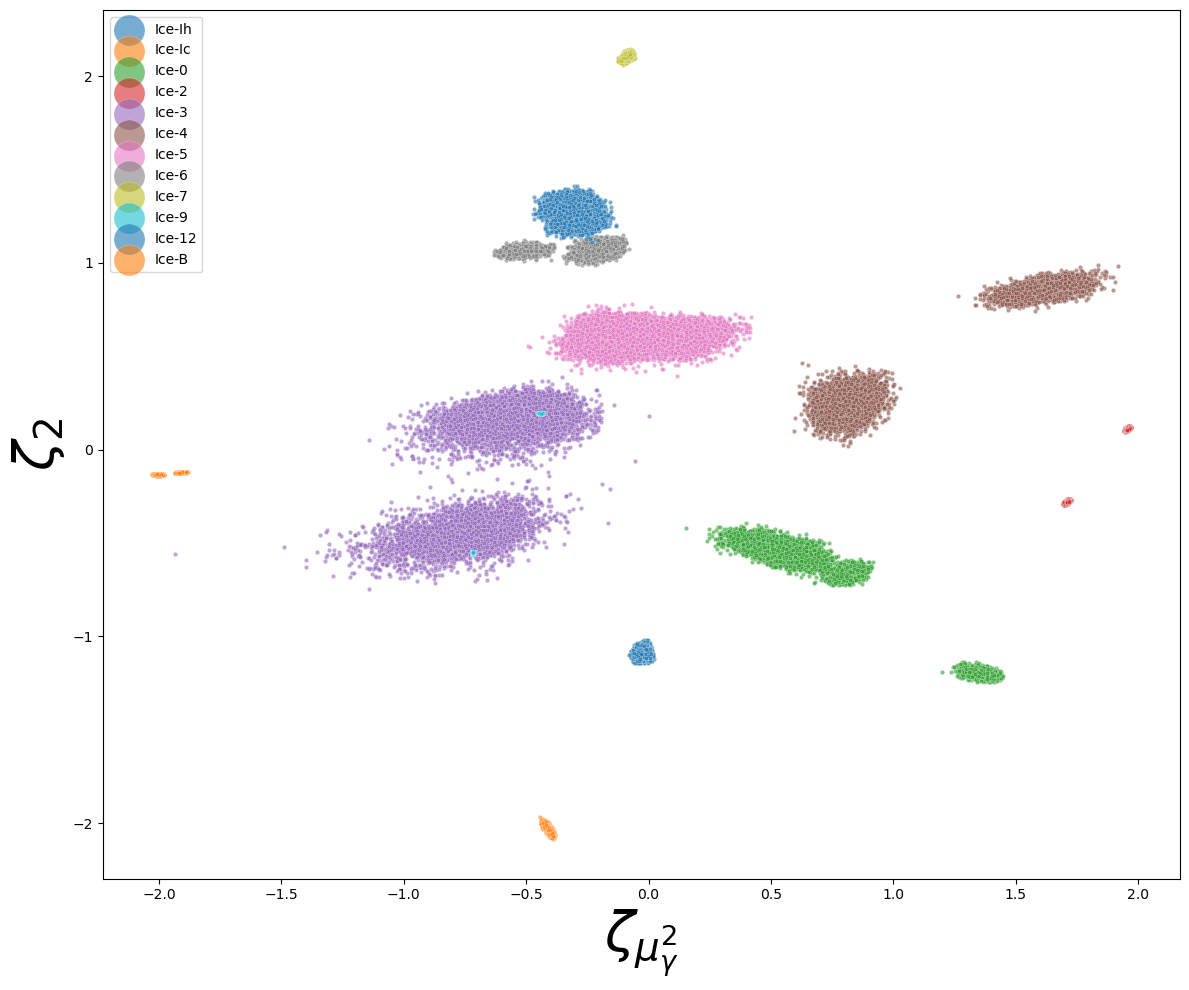

In [248]:
plt.figure(figsize = [12,10])
#pyTrain0 = pyenc.encoder(torch.Tensor(data).to('cuda')).detach().to('cpu').to().numpy()
labels = ["Ice-Ih", "Ice-Ic", "Ice-0", "Ice-2", "Ice-3", "Ice-4", "Ice-5", "Ice-6", "Ice-7", "Ice-9", "Ice-12", "Ice-A", "Ice-B",]
for i in [0,1,2,3,4, 5,6,7,8,9, 10, 12]:
    color = np.array(color_list)
    #if i not in [1,4,5,6,7]:
    sns.scatterplot(x = pyvTrain1[:,0][color==i], y = pyvTrain1[:,1][color==i], s = 10, label = labels[i], alpha = 0.6)
lgnd = plt.legend()
#data0 = pyenc.encoder(torch.Tensor(ice_0_data).to('cuda')).detach().to('cpu').to().numpy() 
#sns.scatterplot(x= data0[:,0], y = data0[:,1], s = 1)
for handle in lgnd.legendHandles:
    handle.set_sizes([500.0])
plt.xlabel("$\zeta_{\mu^2_\gamma}$", fontsize = 40)
plt.ylabel("$\zeta_2$", fontsize = 40)
plt.tight_layout()

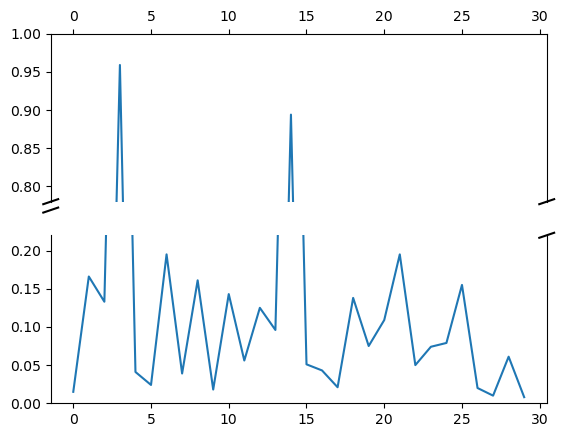

In [209]:
"""
Broken axis example, where the y-axis will have a portion cut out.
"""
import matplotlib.pylab as plt
import numpy as np


# 30 points between 0 0.2] originally made using np.random.rand(30)*.2
pts = np.array([ 0.015,  0.166,  0.133,  0.159,  0.041,  0.024,  0.195,
    0.039, 0.161,  0.018,  0.143,  0.056,  0.125,  0.096,  0.094, 0.051,
    0.043,  0.021,  0.138,  0.075,  0.109,  0.195,  0.05 , 0.074, 0.079,
    0.155,  0.02 ,  0.01 ,  0.061,  0.008])

# Now let's make two outlier points which are far away from everything.
pts[[3,14]] += .8

# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
f,(ax,ax2) = plt.subplots(2,1,sharex=True)

# plot the same data on both axes
ax.plot(pts)
ax2.plot(pts)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.78,1.) # outliers only
ax2.set_ylim(0,.22) # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off') # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-0.015, 0.015), (0.985 + 0.15, 1.015+0.15 ), **kwargs)   # bottom-left diagonal
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
plt.subplot_tool()

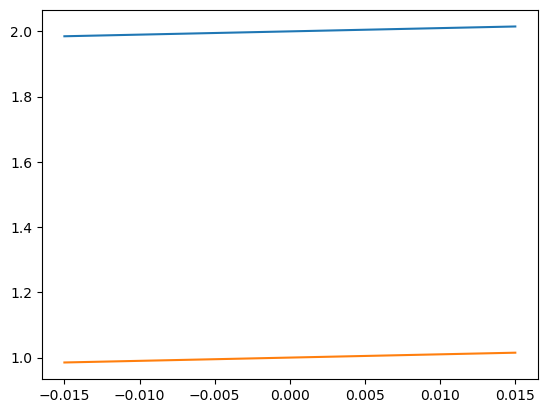

In [203]:
plt.plot((-0.015, 0.015)  , (0.985+1, 1.015+ 1 ))
plt.plot((-0.015, 0.015 )  , (0.985, 1.015 ))

In [191]:
(1-d,1+d),(1-d,1+d)

((0.985, 1.015), (0.985, 1.015))

In [ ]:
ax.set_y